In [9]:
#1 - 라이브러리 & GPU 셋팅
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import os   

# GPU 셋팅
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [10]:
#2 - Data Load

# Download the dataset
data = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [12]:
# 3 - Data Preprocessing

# 마지막 컬럼 전까지는 X로
X = data.values[:,:-1]
# 마지막 컬럼은 Y로
Y = data.values[:,-1]

print('X shape :',X.shape) #=> X shape : (4998, 140)
print('Y shape :',Y.shape) #=> Y shape : (4998,)
# 데이터의 개수가 4998개이며 X는 140개의 feature로 이루어짐.

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=7, stratify=Y)
print('Train shape :',x_train.shape) #=> Train shape : (3998, 140)
print('Test shape :',x_test.shape) #=> Test shape : (1000, 140)

from collections import Counter
print(Counter(y_train)) #=> Counter({True: 2335, False: 1663})
print(Counter(y_test)) #=> Counter({True: 584, False: 416})

# scaling
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) # test set에는 transform만 사용하기

# Data Type 변경
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

X shape : (4998, 140)
Y shape : (4998,)
Train shape : (3998, 140)
Test shape : (1000, 140)
Counter({1.0: 2335, 0.0: 1663})
Counter({1.0: 584, 0.0: 416})


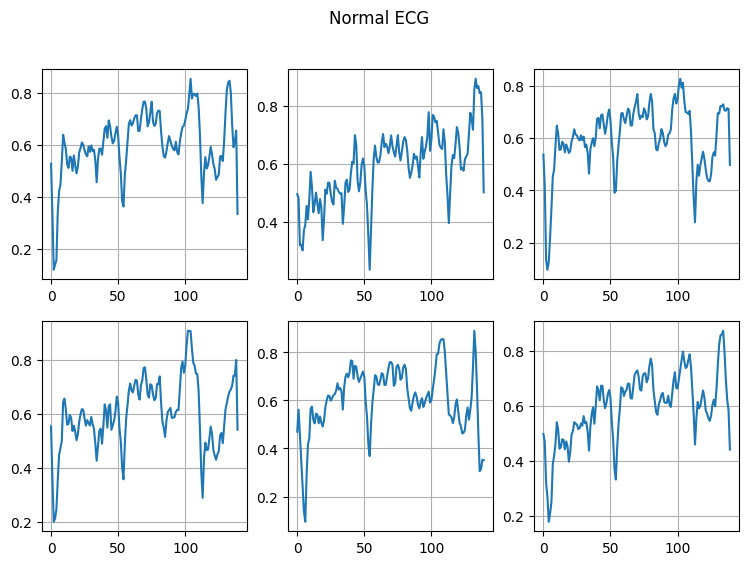

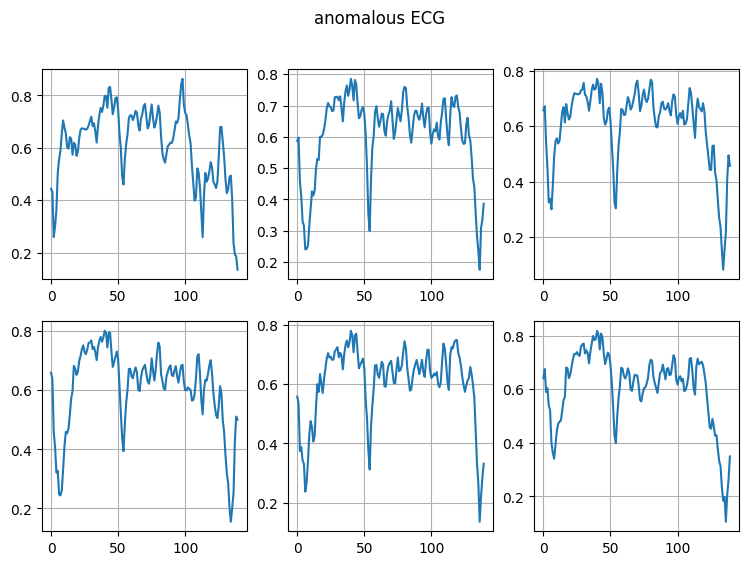

In [15]:
# 4 - 정상/비정상 시각화

# 정상
normal_x_train = x_train[y_train]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("Normal ECG")
ax = ax.ravel() # ax가 3*2차원이기에 for에 1차원으로 만들어 넣기위함
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(normal_x_train[idx])), normal_x_train[idx])
plt.show()

# 비정상
anomalous_x_train = x_train[~y_train]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(9,6))
fig.suptitle("anomalous ECG")
ax = ax.ravel() # ax가 3*2차원이기에 for에 1차원으로 만들어 넣기위함
for idx, ax in enumerate(ax):
    ax.grid()
    ax.plot(np.arange(len(anomalous_x_train[idx])), anomalous_x_train[idx])
plt.show()

In [17]:
# 5 - LSTM(RNN) 모델 생성 및 학습

x_train_ex = tf.expand_dims(x_train, axis=2)
x_test_ex = tf.expand_dims(x_test, axis=2)

print('원본 차원 정보 :',x_train.shape) #=> 원본 차원 정보 : (3998, 140)
print('변경된 차원 정보 :',x_train_ex.shape) #=> 변경된 차원 정보 : (3998, 140, 1)

# (3998, 140, 1)는 각각 아래의 의미를 가짐.
# (데이터 개수, Sequence 길이, Input Vector 길이)

#x_train_ex2 = tf.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
#x_test_ex2 = tf.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
#print('변경된 차원 정보 :',x_train_ex2.shape)
#=> 변경된 차원 정보 : (3998, 140, 1)

# LSTM 모델 생성
model = tf.keras.Sequential([
    layers.LSTM(100, return_sequences=True, input_shape=(x_train_ex.shape[1], x_train_ex.shape[2])),
    layers.Dropout(0.25),
    layers.Bidirectional(layers.LSTM(100)),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

# model = tf.keras.Sequential()
# model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train_ex.shape[1], x_train_ex.shape[2])))
# model.add(layers.Dropout(0.25))
# model.add(layers.Bidirectional(layers.LSTM(100)))
# model.add(layers.Dropout(0.25))
# model.add(layers.Dense(1, activation='sigmoid'))

## RNN으로의 구현
# model = tf.keras.Sequential([
#     layers.RNN(100, return_sequences=True, input_shape=(x_train_ex.shape[1], x_train_ex.shape[2])),
#     layers.Dropout(0.25),
#     layers.Bidirectional(layers.RNN(100)),
#     layers.Dropout(0.25),
#     layers.Dense(1, activation='sigmoid')
# ])

model.summary()

원본 차원 정보 : (3998, 140)
변경된 차원 정보 : (3998, 140, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 140, 100)          40800     
                                                                 
 dropout_2 (Dropout)         (None, 140, 100)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               160800    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 201801 (788.29 KB)
Trainable params: 201801 (788.29 KB)


In [18]:
# 모델 컴파일
model.compile(loss = 'binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [19]:
# 모델 학습
training_record = model.fit(x_train_ex, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(x_train_ex, y_train),
                    shuffle=True)

Epoch 1/30
32/32 [==============================] - 54s 2s/step - loss: 0.4053 - val_loss: 0.1007
Epoch 2/30
32/32 [==============================] - 50s 2s/step - loss: 0.0807 - val_loss: 0.0609
Epoch 3/30
32/32 [==============================] - 48s 1s/step - loss: 0.0653 - val_loss: 0.0657
Epoch 4/30
32/32 [==============================] - 49s 2s/step - loss: 0.0541 - val_loss: 0.0427
Epoch 5/30
32/32 [==============================] - 31s 987ms/step - loss: 0.0476 - val_loss: 0.0380
Epoch 6/30
32/32 [==============================] - 33s 1s/step - loss: 0.0408 - val_loss: 0.0493
Epoch 7/30
32/32 [==============================] - 34s 1s/step - loss: 0.0458 - val_loss: 0.0411
Epoch 8/30
32/32 [==============================] - 34s 1s/step - loss: 0.0424 - val_loss: 0.0387
Epoch 9/30
32/32 [==============================] - 36s 1s/step - loss: 0.0399 - val_loss: 0.0374
Epoch 10/30
32/32 [==============================] - 39s 1s/step - loss: 0.0406 - val_loss: 0.0336
Epoch 11/30
32/3

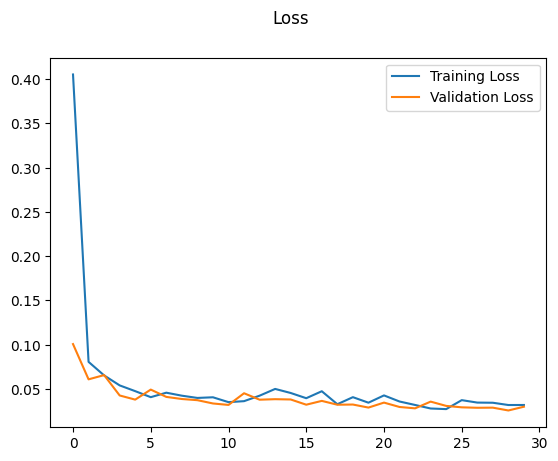

In [20]:
# Learning Curve Visualization

fig, ax = plt.subplots()
plt.plot(training_record.history["loss"], label="Training Loss")
plt.plot(training_record.history["val_loss"], label="Validation Loss")
plt.legend()
fig.suptitle("Loss")
plt.show()

In [21]:
# 6 - 평가

pred_proba = model.predict(x_test_ex)

# Class 판단
# 2차원인 pred_proba를 1차원으로 변경해준다 (1000,1)=>(1000)
pred_proba_1d = pred_proba.reshape(-1)

# 임계치 이상이면 True 미만이면 False를 부여
threshold = 0.5
pred = (pred_proba_1d >= threshold)

# 성능 개선
# Compute the metrics
accuracy_test_rnn= accuracy_score(y_test, pred)
print(f'Accuracy: {accuracy_test_rnn}')
#=> Accuracy: 0.988

precision_test_rnn=precision_score(y_test, pred)
print(f'Precision = {round(precision_test_rnn,3)}')
#=> Precision = 0.99

recall_test_rnn=recall_score(y_test, pred)
print(f'Recall = {round(recall_test_rnn,3)}')
#=> Recall = 0.99

32/32 [==============================] - 3s 46ms/step
Accuracy: 0.993
Precision = 0.993
Recall = 0.995
